In [86]:
%qtconsole

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from bambi.models import Model
import pandas as pd
import pandas.rpy.common as rcom
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats, linalg
import seaborn as sns
from patsy import dmatrices, dmatrix
%matplotlib inline

In [3]:
def plot_traces(traces, burn=50):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[burn:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[burn:]).iterrows()})

    means = [traces[param][50:].mean() for param in traces.varnames]
    for i, mn in enumerate(means):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

# Simulate data with crossed random effects

In [4]:
np.random.seed(12345) # the same combination i have on my luggage!

# set sample sizes
n = int(30)
m = int(30)
half = int(n*m/2)

# basic dataframe with subject/item indicators and predictors
# X1 is continuous, crossed w/ both subj and item
# X2 is categorical, crossed w/ item, but subj nested in X2 (e.g., gender)
# X1 and X2 are correlated, i.e., X1 has higher values for X2=1 than for X2=0
dat = pd.concat([
    pd.DataFrame([(x, y) for x in range(n) for y in range(m)], columns=['subj','item']),
    pd.DataFrame({'X1':np.append(np.random.uniform(size=half, low=0, high=1),
                                 np.random.uniform(size=half, low=.5, high=1.5)),
                  'X2':[0]*half + [1]*half})], axis=1)
# merge in subject random effects
dat = pd.merge(dat, pd.DataFrame({'subj':np.arange(n),
                                  'subj_int':np.random.normal(size=n),
                                  'subj_X1':np.random.normal(size=n)}))
# merge in item random effects
dat = pd.merge(dat, pd.DataFrame({'item':np.arange(m),
                                  'item_int':np.random.normal(size=m),
                                  'item_X1':np.random.normal(size=m),
                                  'item_X2':np.random.normal(size=m)}))
# create Y
dat['Y'] = (1 + dat['subj_int'] + dat['item_int']) + \
    (2 + dat['subj_X1'] + dat['item_X1'])*dat['X1'] + \
    (3 + dat['item_X2'])*dat['X2'] + np.random.normal(size=n*m, scale=5)
# remove true random effects
dat = dat[['subj','item','Y','X1','X2']]

# Add a null 3-level categorical predictor...just for kicks
dat['X3'] = ['a']*int(n*m/3) + ['b']*int(n*m/3) + ['c']*int(n*m/3)

dat.head()

,subj,item,Y,X1,X2,X3
0,0,0,2.274654,0.929616,0,a
1,1,0,4.363795,0.026849,0,a
2,2,0,14.757897,0.383849,0,a
3,3,0,7.848228,0.768735,0,a
4,4,0,4.996840,0.926490,0,a


# Bambi model with fixed effects only

### Using the formula interface

In [73]:
mod0 = Model(dat)
mod0_fitted = mod0.fit('Y ~ X1 + X2 + X3', samples=2000, njobs=2)

Applied log-transform to likelihood_sd and added transformed likelihood_sd_log to model.
Assigned NUTS to b_Intercept
Assigned NUTS to b_X3
Assigned NUTS to b_X1
Assigned NUTS to b_X2
Assigned NUTS to likelihood_sd_log


/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:101: UserWarning: Current Bayesian model has not been built yet; building it first before sampling begins.
  warnings.warn("Current Bayesian model has not been built yet; "


 [-----------------100%-----------------] 2000 of 2000 complete in 10.2 sec

In [74]:
# show the priors for all terms
{x.name:x.prior.args for x in mod0.terms.values()}

{'Intercept': {'mu': 4.1751320103156742, 'sd': 12.222208898454262},
 'X1': {'mu': 0, 'sd': array([ 13.63441861])},
 'X2': {'mu': 0, 'sd': array([ 10.63234065])},
 'X3': {'mu': 0, 'sd': array([ 8.29545759,  8.26442207])}}

In [75]:
mod0_fitted.diagnostics

{'VIF': X1         1.767762
 X2         1.766933
 X3[T.b]    1.333802
 X3[T.c]    1.333455
 dtype: float64,
 'corr_mean_X':               X3[T.b]       X3[T.c]        X1            X2
 X3[T.b]  3.333333e-01 -5.000000e-01 -0.020426 -1.831775e-18
 X3[T.c] -5.000000e-01  3.333333e-01  0.016430 -1.570092e-18
 X1      -2.042636e-02  1.643023e-02  0.754713  6.586684e-01
 X2      -1.831775e-18 -1.570092e-18  0.658668  5.000000e-01}

//anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


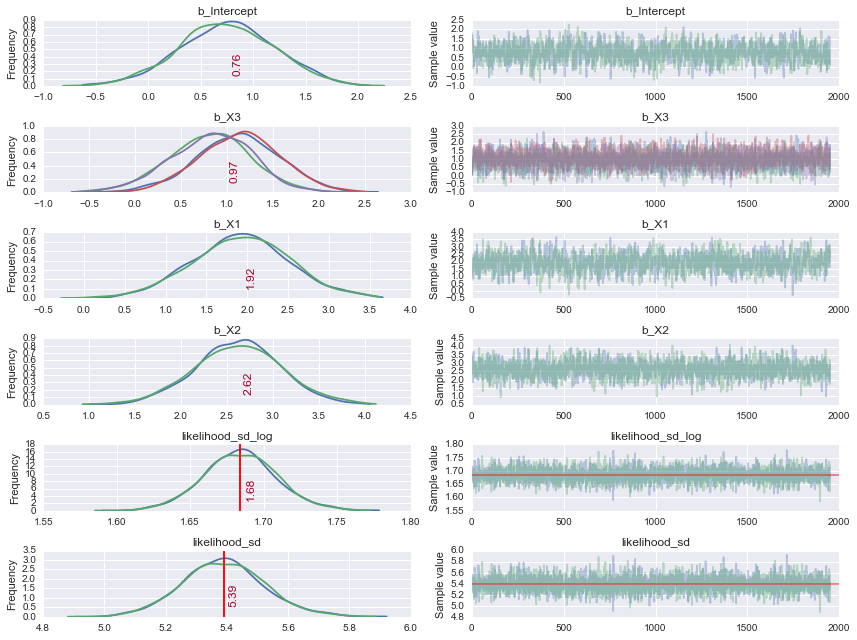

In [76]:
plot_traces(mod0_fitted.trace)

### Compare to OLS model

In [61]:
reg = smf.ols(formula='Y ~ X1 + X2 + X3', data=dat).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     29.18
Date:                Thu, 25 Aug 2016   Prob (F-statistic):           7.94e-23
Time:                        15:33:07   Log-Likelihood:                -2788.6
No. Observations:                 900   AIC:                             5587.
Df Residuals:                     895   BIC:                             5611.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7593      0.478      1.589      0.112        -0.179     1.697
X3[T.b]        1.1262      0.439      2.564      0.010         0.264     1.988
X3[T.c]        0.8140      0.439      1.854      0.064        -0.048     1.676
X1             1.9339      0.625      3.095      0.002         0.707     3.160
X2             2.6191      0.477      5.496      0.000         1.684     3.554
==============================================================================
Omnibus:                        0.362   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.834   Jarque-Bera (JB):                0.409
Skew:                           0.047   Prob(JB):                        0.815
Kurtosis:                       2.953   Cond. No.                         6.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using the term builder

In [62]:
mod0b = Model(dat)
mod0b.add_y('Y')
mod0b.add_intercept()
mod0b.add_term('X1')
mod0b.add_term('X2')
mod0b.add_term('X3')
mod0b.build()
mod0b_fitted = mod0b.fit(samples=2000, njobs=2)

Applied log-transform to likelihood_sd and added transformed likelihood_sd_log to model.
Assigned NUTS to b_Intercept
Assigned NUTS to b_X1
Assigned NUTS to b_X2
Assigned NUTS to b_X3
Assigned NUTS to likelihood_sd_log
 [-----------------100%-----------------] 2000 of 2000 complete in 12.5 sec

In [63]:
# show the priors for all terms
{x.name:x.prior.args for x in mod0b.terms.values()}

{'Intercept': {'mu': 4.1751320103156742, 'sd': 12.222208898454266},
 'X1': {'mu': 0, 'sd': array([ 13.63441861])},
 'X2': {'mu': 0, 'sd': array([ 10.63234065])},
 'X3': {'mu': 0, 'sd': array([ 8.29545759,  8.26442207])}}

//anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


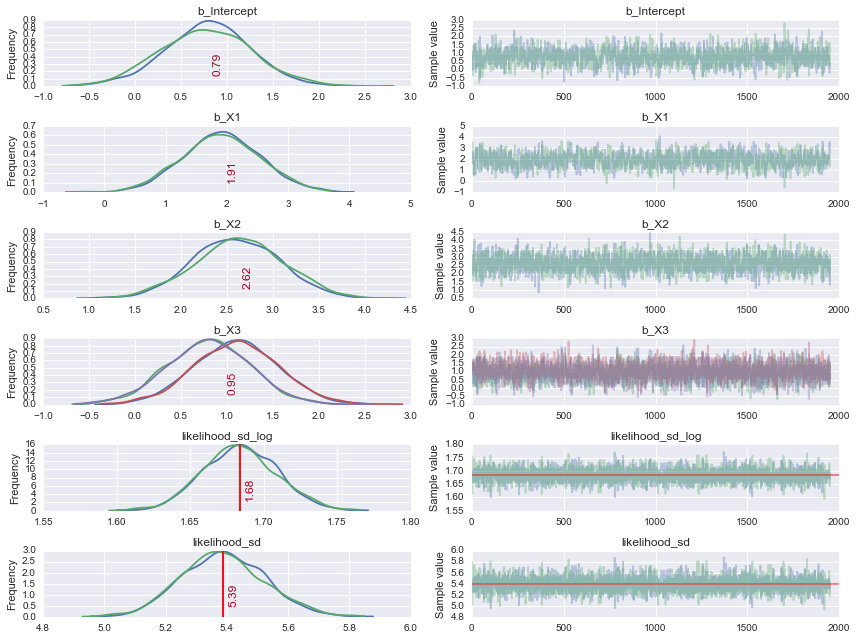

In [64]:
plot_traces(mod0b_fitted.trace)

# Full model in Bambi (note: no random X3 slopes)

In [65]:
mod1 = Model(dat)
mod1_fitted = mod1.fit('Y ~ X1 + X2 + X3',
                       random=['1|subj','1|item','X1|subj','X1|item','X2|item'],
                      samples=2000, njobs=2)

Applied log-transform to u_subj_sd and added transformed u_subj_sd_log to model.
Applied log-transform to u_item_sd and added transformed u_item_sd_log to model.
Applied log-transform to u_X1|subj_sd and added transformed u_X1|subj_sd_log to model.
Applied log-transform to u_X1|item_sd and added transformed u_X1|item_sd_log to model.
Applied log-transform to u_X2|item_sd and added transformed u_X2|item_sd_log to model.
Applied log-transform to likelihood_sd and added transformed likelihood_sd_log to model.
Assigned NUTS to b_Intercept
Assigned NUTS to b_X3
Assigned NUTS to b_X1
Assigned NUTS to b_X2
Assigned NUTS to u_subj_sd_log
Assigned NUTS to u_subj
Assigned NUTS to u_item_sd_log
Assigned NUTS to u_item
Assigned NUTS to u_X1|subj_sd_log
Assigned NUTS to u_X1|subj
Assigned NUTS to u_X1|item_sd_log
Assigned NUTS to u_X1|item
Assigned NUTS to u_X2|item_sd_log
Assigned NUTS to u_X2|item
Assigned NUTS to likelihood_sd_log


/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:98: UserWarning: Current Bayesian model has not been built yet; building it first before sampling begins.
  warnings.warn("Current Bayesian model has not been built yet; "


 [-----------------100%-----------------] 2000 of 2000 complete in 169.8 sec

In [66]:
# show prior args for fixed terms
{x.name:x.prior.args for x in mod1.terms.values() if x.type_=="fixed"}

{'Intercept': {'mu': 4.1751320103156742, 'sd': 12.222208898454262},
 'X1': {'mu': 0, 'sd': array([ 13.63441861])},
 'X2': {'mu': 0, 'sd': array([ 10.63234065])},
 'X3': {'mu': 0, 'sd': array([ 8.29545759,  8.26442207])}}

In [67]:
# show prior args for random terms
{x.name:x.prior.args['sd'].args for x in mod1.terms.values() if x.type_=="random"}

{'X1|item': {'beta': 13.634418608400614},
 'X1|subj': {'beta': 13.634418608400614},
 'X2|item': {'beta': 10.632340650775394},
 'item': {'beta': 12.222208898454262},
 'subj': {'beta': 12.222208898454262}}

//anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


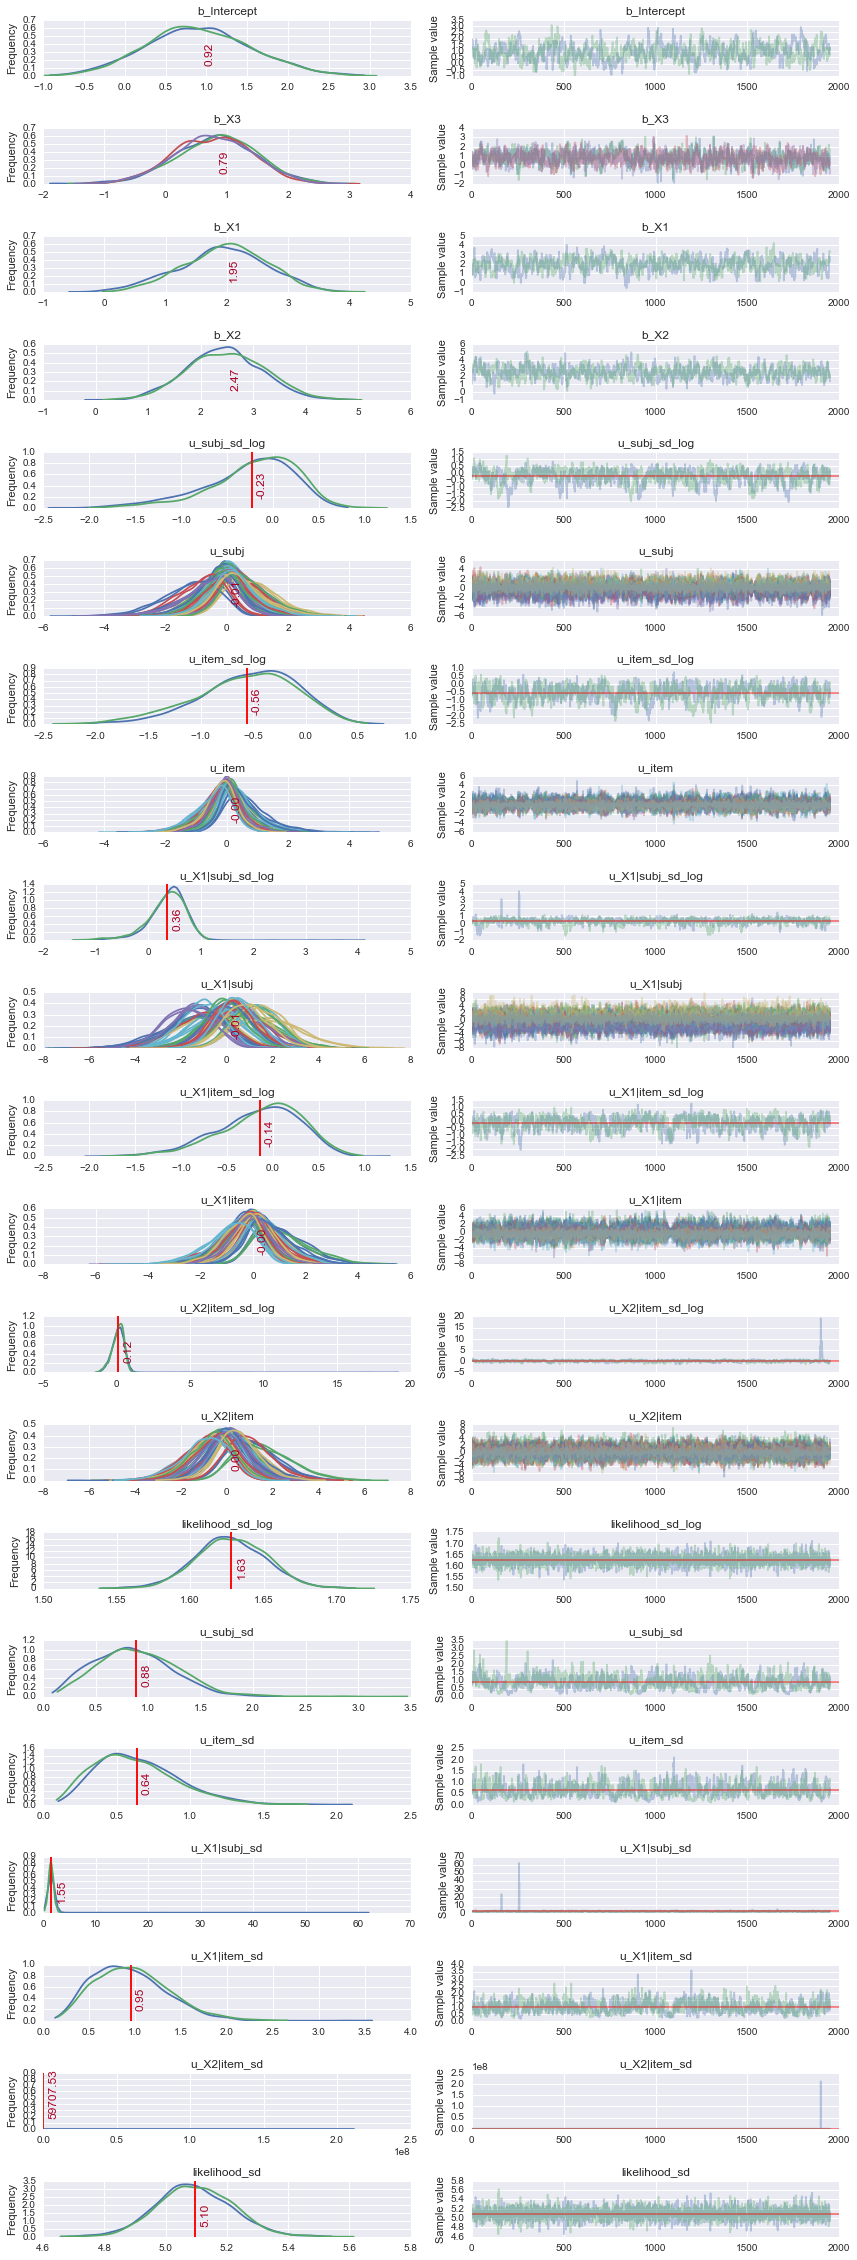

In [68]:
plot_traces(mod1_fitted.trace)

# For reference, here's what the full mixed model looks like in lme4

In [181]:
# dat.to_csv('/Users/Jake/Desktop/prior_test.csv')

### model w/ *correlated* random effects (overparameterized since true correlations = 0):
### Y ~ X1 + X2 + (X1|subj) + (X1 + X2|item)
# Random effects:
#  Groups   Name        Variance Std.Dev. Corr       
#  subj     (Intercept)  0.1934  0.4398              
#           X1           1.5571  1.2478   1.00       
#  item     (Intercept)  0.0000  0.0000              
#           X1           1.8536  1.3615     NaN      
#           X2           1.9193  1.3854     NaN -0.49
#  Residual             25.8127  5.0806              
# Number of obs: 900, groups:  subj, 30; item, 30

# Fixed effects:
#             Estimate Std. Error t value
# (Intercept)   0.8961     0.5439   1.648
# X1            1.9629     0.6918   2.837
# X2            2.4735     0.7019   3.524
# X3b           0.8156     0.5503   1.482
# X3c           0.8065     0.5548   1.454
### MODEL FAILED TO CONVERGE

### model w/ *uncorrelated* random effects (the correct model):
### Y ~ X1 + X2 + (X1||subj) + (X1 + X2||item)
# Random effects:
#  Groups   Name        Variance Std.Dev.
#  subj     (Intercept)  0.4840  0.6957  
#  subj.1   X1           2.3248  1.5247  
#  item     (Intercept)  0.0000  0.0000  
#  item.1   X1           1.1067  1.0520  
#  item.2   X2           0.9152  0.9567  
#  Residual             25.9145  5.0906  
# Number of obs: 900, groups:  subj, 30; item, 30

# Fixed effects:
#             Estimate Std. Error t value
# (Intercept)   0.8741     0.5522   1.583
# X1            1.9541     0.6924   2.822
# X2            2.4930     0.6686   3.729
# X3b           0.8140     0.5494   1.482
# X3c           0.8312     0.5533   1.502
### MODEL CONVERGED SUCCESSFULLY

# Model with random X3 slopes for subjects

### This is currently a problematic case. The model seems to only be adding a single random X3 slope term for each subject, but it should be adding two random X3 slope terms, since X3 is a 3-level categorical predictor coded using 2 dummy codes. When this issue is resolved, the corresponding code that handles default priors for this case will likely need to be revised

In [69]:
mod2 = Model(dat)
mod2_fitted = mod2.fit('Y ~ X1 + X2 + X3', categorical='X3',
                       random=['1|subj','X3|subj'],
                      samples=2000, njobs=2)

Applied log-transform to u_subj_sd and added transformed u_subj_sd_log to model.
Applied log-transform to u_X3|subj_sd and added transformed u_X3|subj_sd_log to model.
Applied log-transform to likelihood_sd and added transformed likelihood_sd_log to model.
Assigned NUTS to b_Intercept
Assigned NUTS to b_X3
Assigned NUTS to b_X1
Assigned NUTS to b_X2
Assigned NUTS to u_subj_sd_log
Assigned NUTS to u_subj
Assigned NUTS to u_X3|subj_sd_log
Assigned NUTS to u_X3|subj
Assigned NUTS to likelihood_sd_log


/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:101: UserWarning: Current Bayesian model has not been built yet; building it first before sampling begins.
  if run:


 [-----------------100%-----------------] 2001 of 2000 complete in 144.5 sec

In [70]:
# show prior args for fixed terms
{x.name:x.prior.args for x in mod2.terms.values() if x.type_=="fixed"}

{'Intercept': {'mu': 4.1751320103156742, 'sd': 12.222208898454262},
 'X1': {'mu': 0, 'sd': array([ 13.63441861])},
 'X2': {'mu': 0, 'sd': array([ 10.63234065])},
 'X3': {'mu': 0, 'sd': array([ 8.29545759,  8.26442207])}}

In [71]:
# show prior args for random terms
{x.name:x.prior.args['sd'].args for x in mod2.terms.values() if x.type_=="random"}

{'X3|subj': {'beta': 1}, 'subj': {'beta': 12.222208898454262}}

//anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


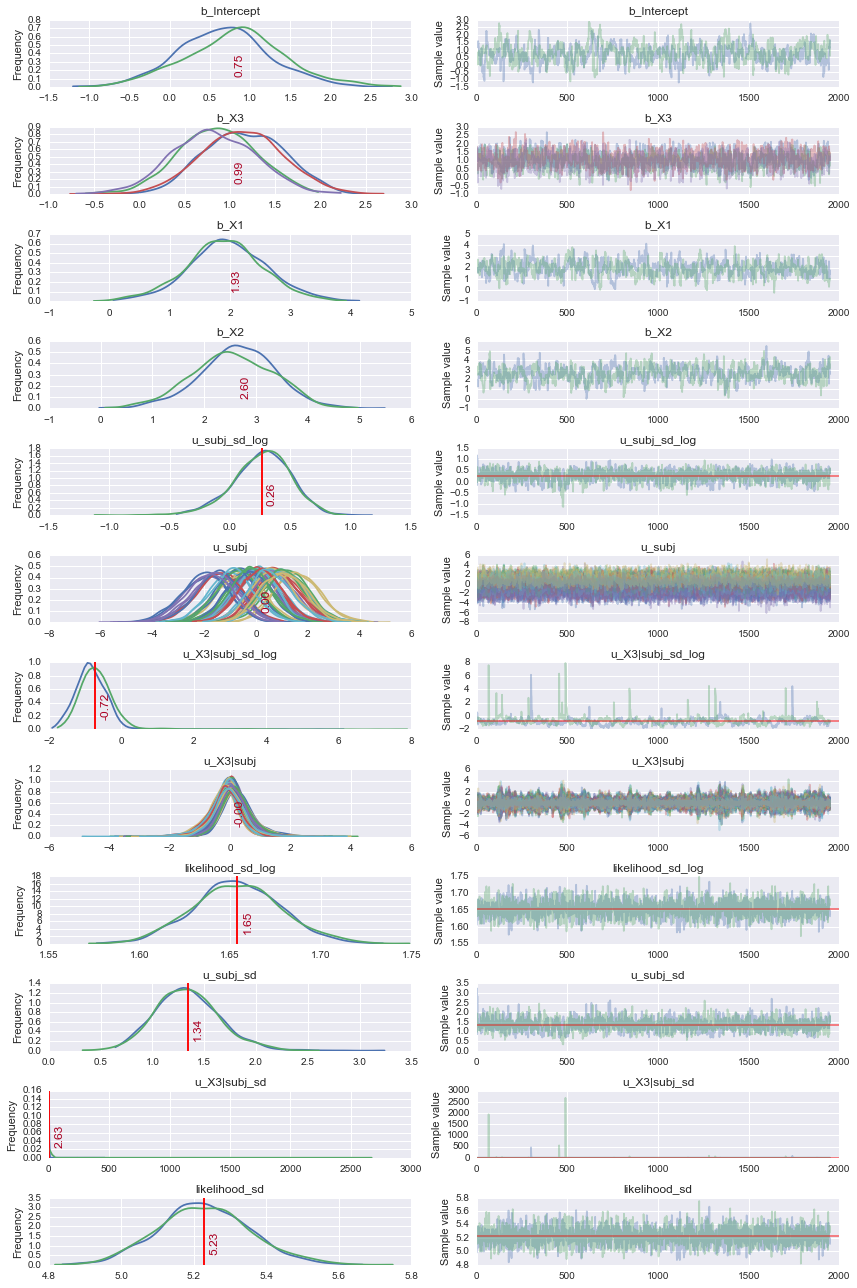

In [72]:
plot_traces(mod2_fitted.trace)